In [41]:
!pip install transformers datasets torch tqdm

In [42]:
import torch
import huggingface_hub
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTModel
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Compose
import pandas as pd
from torch import nn
from torchvision.datasets import ImageFolder
from torch.optim import AdamW
from tqdm import tqdm
from torchvision import transforms

In [43]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])


/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [44]:
dataset = ImageFolder(root='/kaggle/input/medical-previous-group/Medical Waste 4.0 (Previous group)', transform=transform)

def my_collate_fn(batch):
    # Manually handle variable sizes by padding or other means
    # For simplicity, we're just showing an example where you might need this
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    # Implement resizing or padding here if needed
    images = torch.stack([transforms.Resize((224, 224))(image) for image in images])
    labels = torch.tensor(labels)
    return images, labels

# Splitting the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=my_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=my_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=my_collate_fn)

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
from transformers import ViTForImageClassification
from torch import nn

class CustomViTForImageClassification(nn.Module):
    def __init__(self, num_labels):
        super(CustomViTForImageClassification, self).__init__()
        # Load the base model without the classification head
        self.base_model = ViTModel.from_pretrained('google/vit-base-patch16-224')

        # Freezing the parameters of the base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Adding new layers that will be fine-tuned
        self.dropout = nn.Dropout(0.5)
        self.intermediate = nn.Linear(768, 512)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(512, num_labels)

        # These new layers will have requires_grad=True by default

    def forward(self, pixel_values):
        # Use the base model to compute the initial outputs
        outputs = self.base_model(pixel_values)
        # Use the last hidden state
        x = outputs.last_hidden_state[:, 0]  # Assuming you want the first token (like [CLS] in BERT)
        x = self.dropout(x)
        x = self.intermediate(x)
        x = self.relu(x)
        x = self.classifier(x)
        return x

# Assuming you have a defined dataset and device setup
num_labels = len(dataset.classes)  # Make sure 'dataset.classes' is defined as per your dataset
model = CustomViTForImageClassification(num_labels=num_labels)
model.to(device)  # Ensure model is on the right device


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomViTForImageClassification(
  (base_model): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(

In [47]:
# Assuming you've defined and loaded your custom model as 'model'
model = CustomViTForImageClassification(num_labels=len(dataset.classes))
model.to(device)  # Ensure model is on the right device


# Setup optimizer - Only optimize the parameters of the new layers
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    for d in tqdm(data_loader):
        inputs, labels = d[0].to(device), d[1].to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)  # Assuming 'outputs' are logits
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return correct_predictions.double() / len(data_loader.dataset), sum(losses) / len(losses)

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            inputs, labels = d[0].to(device), d[1].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)  # Assuming 'outputs' are logits
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    return correct_predictions.double() / len(data_loader.dataset), sum(losses) / len(losses)

# Training loop remains the same


loss_fn = torch.nn.CrossEntropyLoss()
metrics = []

for epoch in range(10):
    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_acc, val_loss = eval_model(model, val_loader, loss_fn, device)
    metrics.append({'epoch': epoch+1, 'train_accuracy': train_acc, 'train_loss': train_loss,
                    'val_accuracy': val_acc, 'val_loss': val_loss})
    print(f"Epoch {epoch+1}, Train Acc: {train_acc}, Train Loss: {train_loss}, Val Acc: {val_acc}, Val Loss: {val_loss}")

# Convert metrics to DataFrame and save as CSV
df = pd.DataFrame(metrics)
df.to_csv('training_metrics.csv', index=False)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 186/186 [01:01<00:00,  3.05it/s]


Epoch 1, Train Acc: 0.4628071356445641, Train Loss: 2.0059946967709448, Val Acc: 0.8113207547169812, Val Loss: 1.3290114879608155


100%|██████████| 186/186 [01:01<00:00,  3.04it/s]


Epoch 2, Train Acc: 0.7593402894648267, Train Loss: 1.0666554345879504, Val Acc: 0.839622641509434, Val Loss: 0.7203819274902343


100%|██████████| 186/186 [01:01<00:00,  3.04it/s]


Epoch 3, Train Acc: 0.8320430831369909, Train Loss: 0.6742065254078117, Val Acc: 0.8710691823899371, Val Loss: 0.5102708011865615


100%|██████████| 186/186 [01:01<00:00,  3.04it/s]


Epoch 4, Train Acc: 0.8640188488724335, Train Loss: 0.5032062838154454, Val Acc: 0.889937106918239, Val Loss: 0.4077802449464798


100%|██████████| 186/186 [01:01<00:00,  3.04it/s]


Epoch 5, Train Acc: 0.8832043083136991, Train Loss: 0.4140147195067457, Val Acc: 0.9072327044025158, Val Loss: 0.35032584965229036


100%|██████████| 186/186 [01:00<00:00,  3.06it/s]


Epoch 6, Train Acc: 0.8973409626388422, Train Loss: 0.3579945154888656, Val Acc: 0.9040880503144655, Val Loss: 0.30931574404239653


100%|██████████| 186/186 [01:00<00:00,  3.07it/s]


Epoch 7, Train Acc: 0.9067653988556041, Train Loss: 0.315521264949473, Val Acc: 0.919811320754717, Val Loss: 0.283462880551815


100%|██████████| 186/186 [01:00<00:00,  3.05it/s]


Epoch 8, Train Acc: 0.9155166610568832, Train Loss: 0.28371539351440245, Val Acc: 0.9072327044025158, Val Loss: 0.27368067800998686


100%|██████████| 186/186 [01:01<00:00,  3.04it/s]


Epoch 9, Train Acc: 0.9161898350723663, Train Loss: 0.2677703529035532, Val Acc: 0.9323899371069183, Val Loss: 0.2446112021803856


100%|██████████| 186/186 [01:00<00:00,  3.06it/s]


Epoch 10, Train Acc: 0.9222484012117133, Train Loss: 0.24429314989115922, Val Acc: 0.9323899371069183, Val Loss: 0.22941496819257737


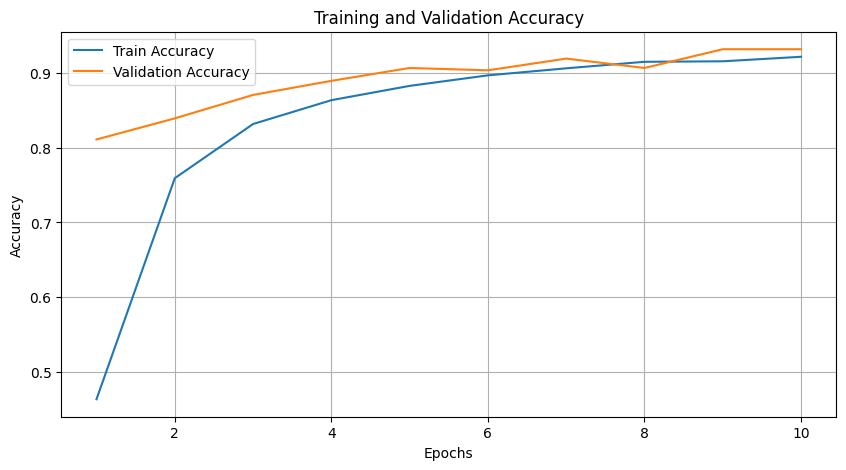

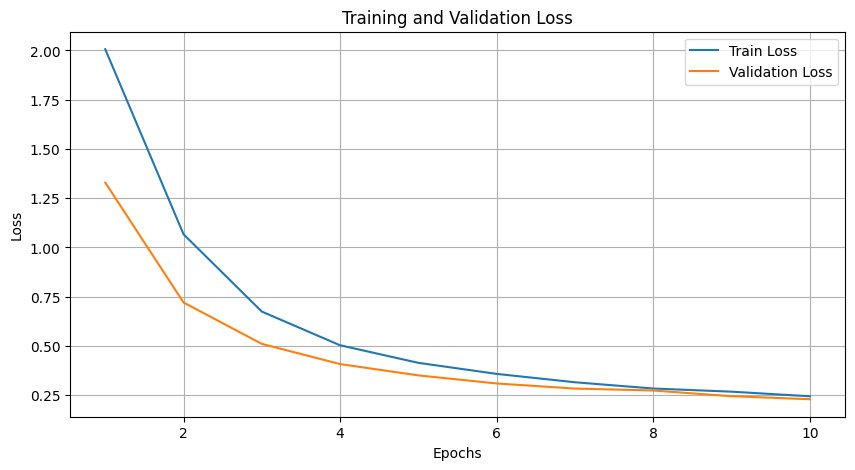

In [48]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_accuracy'], label='Train Accuracy')
plt.plot(df['epoch'], df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for d in data_loader:
            inputs, labels = d[0].to(device), d[1].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels).item()  # Convert to Python int immediately
            losses.append(loss.item())  # Convert to Python float immediately
            predictions.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy array
            actuals.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy array

    total_correct = correct_predictions  # This is already a Python scalar
    total = len(data_loader.dataset)
    total_loss = sum(losses)
    test_acc = total_correct / total
    test_loss = total_loss / len(losses)

    return test_acc, test_loss, predictions, actuals


# Example setup (replace with your actual setup)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()

# Assuming 'test_loader' is already defined
test_acc, test_loss, predictions, actuals = eval_model(model, test_loader, loss_fn, device)

# Print the results
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")


Test Accuracy: 0.92, Test Loss: 0.23


In [50]:
torch.save(model.state_dict(), '/kaggle/working/vit_model_freezed_params_10_epochs_model.pth')

In [51]:
# Create a DataFrame with the test results
test_results = pd.DataFrame({
    'Test Accuracy': [test_acc],
    'Test Loss': [test_loss]
})

# Save the DataFrame to a CSV file
test_results.to_csv('/kaggle/working/test_metrics_vit_10_epochs_freezed_params.csv', index=False)


Test Accuracy: 0.9247648902821317, Test Loss: 0.22617981731891632


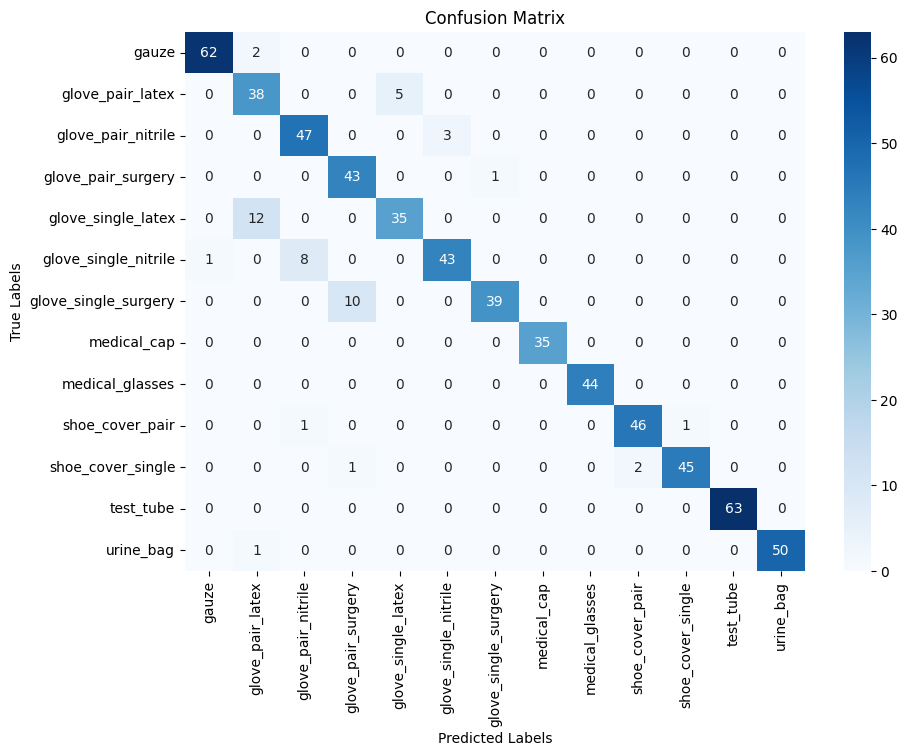

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example call to the function (assuming 'test_loader', 'model', 'loss_fn', and 'device' are defined)
test_acc, test_loss, predictions, actuals = eval_model(model, test_loader, loss_fn, device)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

# Calculate the confusion matrix
cm = confusion_matrix(actuals, predictions, labels=np.arange(len(dataset.classes)))  # Adjust labels if necessary

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
